In [7]:
import pandas as pd
import shap

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


PATH_PROJECT = "/home/yoshraf/projects/mestrado/"

X_train = pd.read_parquet(f"{PATH_PROJECT}data/counting_trips/X_train.parquet")
X_test = pd.read_parquet(f"{PATH_PROJECT}data/counting_trips/X_test.parquet")
y_train = pd.read_parquet(f"{PATH_PROJECT}data/counting_trips/y_train.parquet")
y_test = pd.read_parquet(f"{PATH_PROJECT}data/counting_trips/y_test.parquet")


In [8]:
shap.initjs()

In [9]:
def valid_model(y_train, y_test, y_pred_train, y_pred_test):
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    print("----Train---")
    print(f"MAE: {mae_train:.2f}")
    print(f"MSE: {mse_train:.2f}")
    print(f"R2: {r2_train:.2f}")
    print("---- Test ---")
    print(f"MAE: {mae_test:.2f}")
    print(f"MSE: {mse_test:.2f}")
    print(f"R2: {r2_test:.2f}")
    return None

def rf_modeling(X_train, X_test, y_train, y_test, params):
    reg = RandomForestRegressor(**params)
    reg.fit(X_train, y_train.values.ravel())
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    feats = {}
    for feature, importance in zip(X_train.columns, reg.feature_importances_):
        feats[feature] = importance * 100
    df_imp = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'}).sort_values("Importance", ascending=False)
    print("Main Features:")
    print(df_imp.head(10))
    valid_model(y_train, y_test, y_pred_train, y_pred_test)
    return reg


rf_params = {"n_estimators": 100, "max_depth": 12, "random_state": 0, "min_samples_leaf": 30, "max_features": "auto", "max_samples": .8, "n_jobs": -1}
reg = rf_modeling(X_train, X_test, y_train, y_test, rf_params)

Main Features:
                                            Importance
loc_domicilio_count_ilum_std                 56.815899
loc_domicilio_count_parada                   24.754351
Estuda atualmente?__outros_                   4.081653
Condição de atividade_Tem Trabalho Regular    3.750698
loc_domicilio_dist_metro                      1.702467
loc_domicilio_ACC_TP_A_E_60M                  1.571325
loc_domicilio_dist_term                       1.312651
Pontos Critério Brasil                        0.839764
per Renda familiar mensal                     0.797228
loc_domicilio_ACC_TI_A_L_TI_                  0.773938
----Train---
MAE: 0.50
MSE: 0.59
R2: 0.76
---- Test ---
MAE: 0.52
MSE: 0.64
R2: 0.74


In [11]:
reg = rf_modeling(X_train, X_test, y_train, y_test, {})

Main Features:
                                            Importance
loc_domicilio_count_ilum_std                 44.714536
loc_domicilio_count_parada                   20.687423
Estuda atualmente?__outros_                   3.159957
loc_domicilio_dist_term                       3.119576
loc_domicilio_dist_metro                      3.088029
Condição de atividade_Tem Trabalho Regular    2.873355
loc_domicilio_dist_trem                       2.572310
per Renda familiar mensal                     2.395546
loc_domicilio_ACC_TP_A_E_60M                  2.364904
loc_domicilio_dist_ciclo                      2.262454
----Train---
MAE: 0.16
MSE: 0.07
R2: 0.97
---- Test ---
MAE: 0.41
MSE: 0.47
R2: 0.81


In [4]:
explainer = shap.Explainer(reg)
shap_values = explainer(X_test)

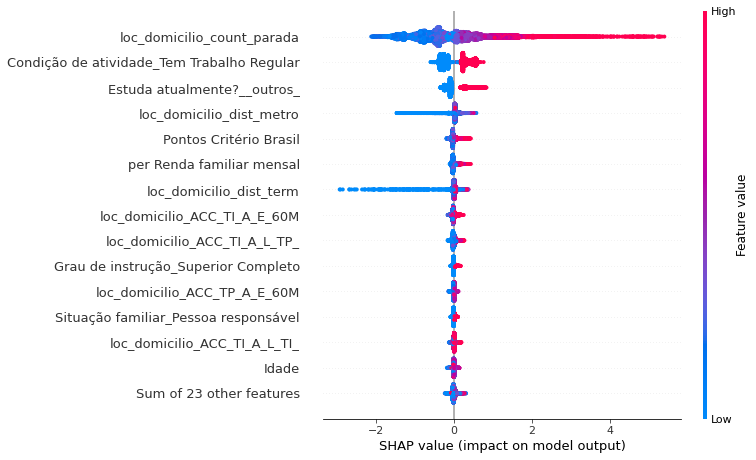

In [5]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=15)

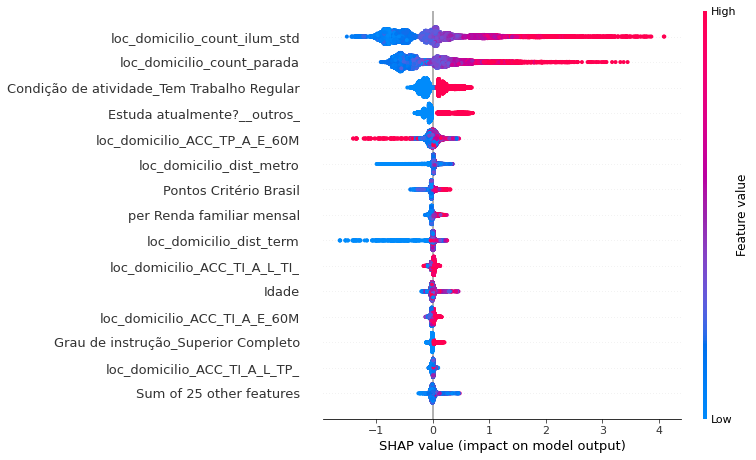

In [40]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=15)

In [92]:
class ShapObject:
    
    def __init__(self, base_values, data, values, feature_names):
        self.base_values = base_values # Single value
        self.data = data # Raw feature values for 1 row of data
        self.values = values # SHAP values for the same row of data
        self.feature_names = feature_names # Column names

In [107]:
y_test.sort_values(by="Total de viagens da pessoa", ascending=False)[10:20]

,,,,,Total de viagens da pessoa
Identifica pessoa,Zona de domicílio,Data da entrevista,Coordenada X domicílio,Coordenada Y domicílio,
02440429101,244.0,21052018,337847.0,7387383.0,10.0
01370010102,137.0,30112017,331425.0,7400741.0,10.0
00920358101,92.0,01062018,329827.0,7397561.0,10.0
02740453103,274.0,02032018,332476.0,7384425.0,10.0
03040322101,304.0,08082018,320777.0,7382369.0,10.0
00871320101,87.0,11112017,327867.0,7394969.0,10.0
01870036102,187.0,29052018,350857.0,7401688.0,10.0
00741219102,74.0,27062018,331017.0,7392767.0,10.0
02570996101,257.0,23092018,343018.0,7390179.0,10.0


Total de viagens da pessoa    4.0
Name: (00550032103, 55.0, 14042018, 331790.0, 7390037.0), dtype: float64


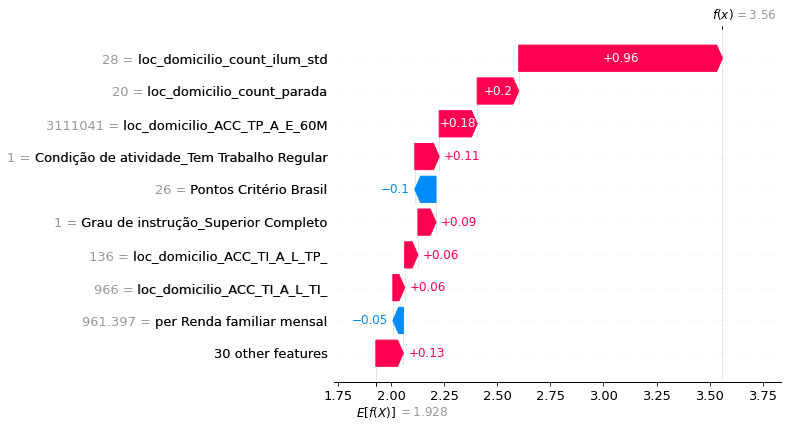

In [116]:
row = 10
shap_object = ShapObject(base_values = shap_values[row].base_values[0],
                         values = shap_values[row].values,
                         feature_names = X_test.columns,
                         data = X_test.iloc[row])
print(y_test.iloc[row])
shap.waterfall_plot(shap_object)

Total de viagens da pessoa    0.0
Name: (00990345107, 99.0, 04112017, 325596.0, 7398532.0), dtype: float64


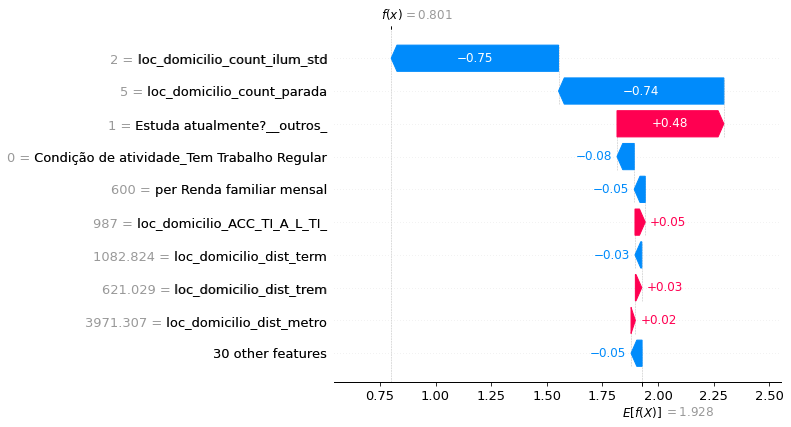

In [115]:
row = 52
shap_object = ShapObject(base_values = shap_values[row].base_values[0],
                         values = shap_values[row].values,
                         feature_names = X_test.columns,
                         data = X_test.iloc[row])
print(y_test.iloc[row])
shap.waterfall_plot(shap_object)

In [113]:
y_test.iloc[52]

Total de viagens da pessoa    0.0
Name: (00990345107, 99.0, 04112017, 325596.0, 7398532.0), dtype: float64

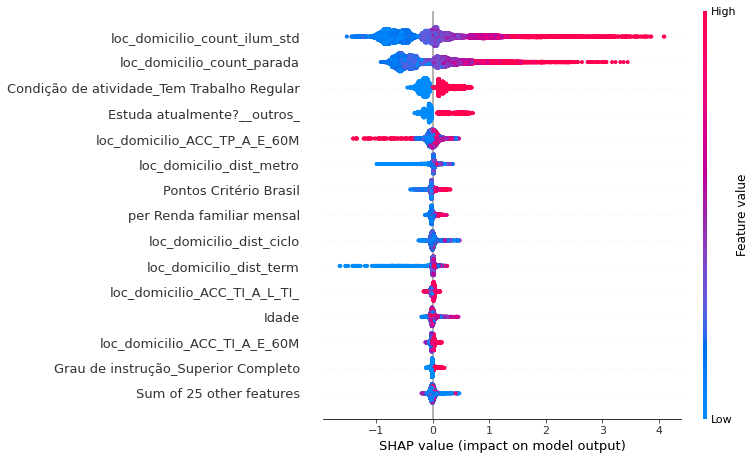

In [112]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=15)